In [1]:
%reset -sf

import sys
sys.path.insert(0, '../qe')
import os
import glob
import shutil
import gc

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
# GPU(s) setups
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
# tf.config.experimental.set_memory_growth(gpus[1], True)
# print(tf.config.list_physical_devices(), end='\n\n')
# GPU(s) setups
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the second GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
print(tf.__version__)

2 Physical GPUs, 1 Logical GPU
2.13.0


In [2]:
model = tf.keras.models.load_model('./w_lead_result/dnn_w_lead_full_scaled.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4096)              45056     
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_4 (Dense)             (None, 1024)              209817

In [3]:
branches = [
			"reco_e", 
			"reco_m", 
			"reco_leadlep", 
			"reco_subleadlep", 
			"reco_met", 
			"truth_e", 
			"truth_m", 
			"truth_leadlep", 
			"truth_subleadlep", 
			"truth_w", 
			"truth_h", 
			"truth_leadw", 
			"truth_subleadw", 
			"truth_met", 
			"truth_nu", 
			"truth_Bij"
			]

data = {}
for branch in branches:
	data[branch] = pd.read_hdf("/root/data/recotruth/full_345324_data.h5", key=branch)

FileNotFoundError: File /root/data/recotruth/full_345324_data.h5 does not exist

In [ ]:
lead = data["reco_leadlep"][["RecoLeadLepE", "RecoLeadLepPx", "RecoLeadLepPy", "RecoLeadLepPz"]]
sublead = data["reco_subleadlep"][["RecoSubleadLepE", "RecoSubleadLepPx", "RecoSubleadLepPy", "RecoSubleadLepPz"]]
met = data["reco_met"][["RecoMETPx", "RecoMETPy"]]
w_lead = data["truth_leadw"][["TruthRecoLeadWE", "TruthRecoLeadWPx", "TruthRecoLeadWPy", "TruthRecoLeadWPz"]]

obs_var = pd.concat([lead, sublead, met], axis=1) / 1e3
int_var = w_lead / 1e3

del lead, sublead, met, w_lead, data
gc.collect()

31105

In [ ]:
ROBUST_OBS = RobustScaler()
obs_var = ROBUST_OBS.fit_transform(obs_var)
ROBUST_INT = RobustScaler().fit(int_var)
int_var = int_var.to_numpy()

In [ ]:
pred_int = model.predict(obs_var)

11188/11188 [==============================] - 28s 2ms/step


In [ ]:
pred_int = ROBUST_INT.inverse_transform(pred_int)

Truth mean: 160.217, std: 115.160, min: 26.392, max: 1795.587


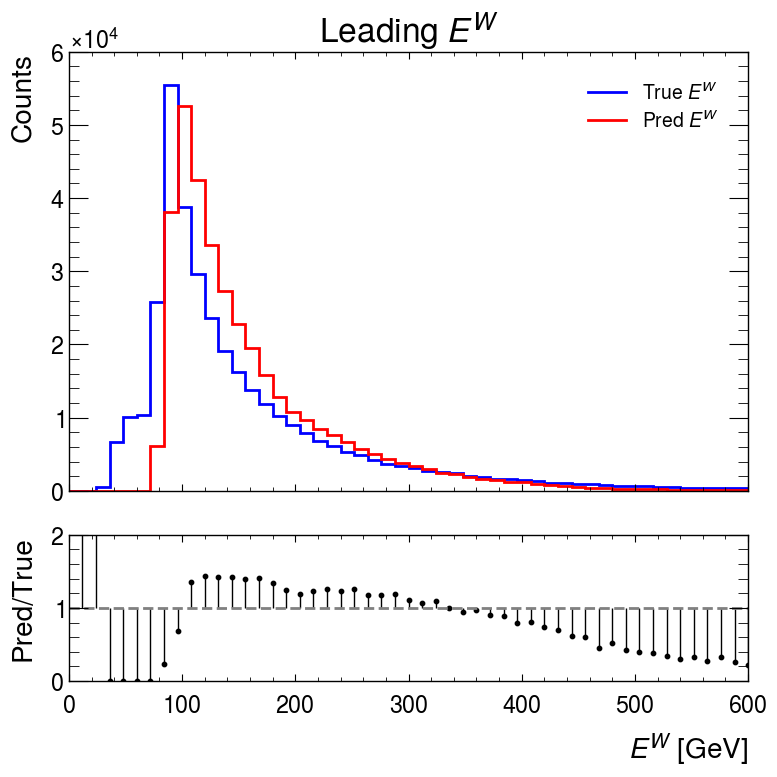

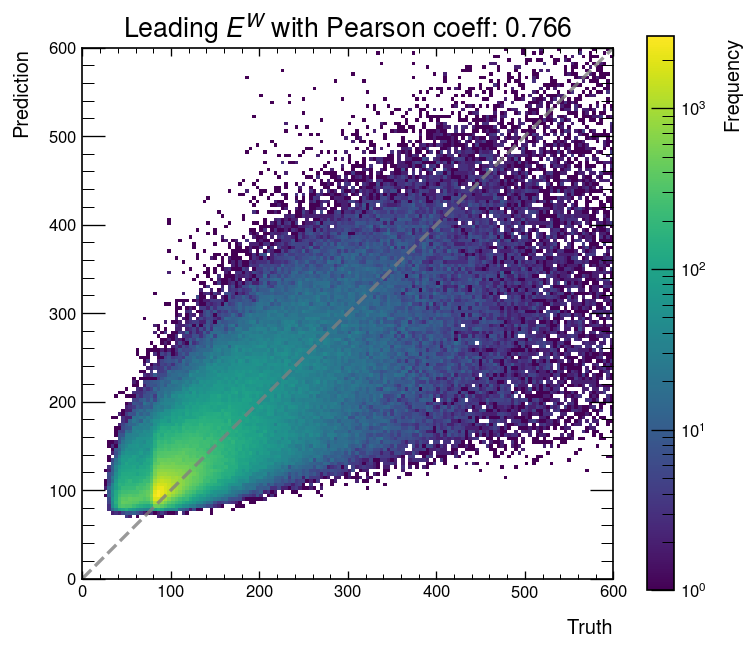

In [ ]:
x, y = int_var[:,0], pred_int[:,0]
print(
    f"Truth mean: {np.mean(x):.3f}, std: {np.std(x):.3f}, min: {np.min(x):.3f}, max: {np.max(x):.3f}"
)

range = [0, 600]

plot.hist(
    data=[x, y],
    label=r"$E^{W}$",
    title="Leading $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(x, y):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    x,
    y,
    r"Leading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(x, y)[0]:.3f}",
    range=range,
)

Truth mean: -0.013, std: 38.257, min: -680.455, max: 793.779


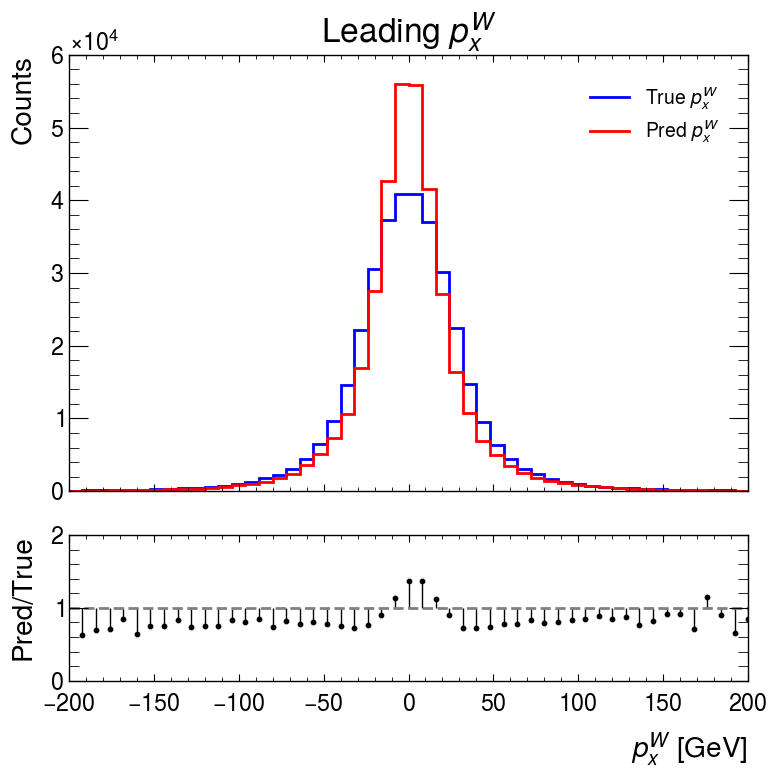

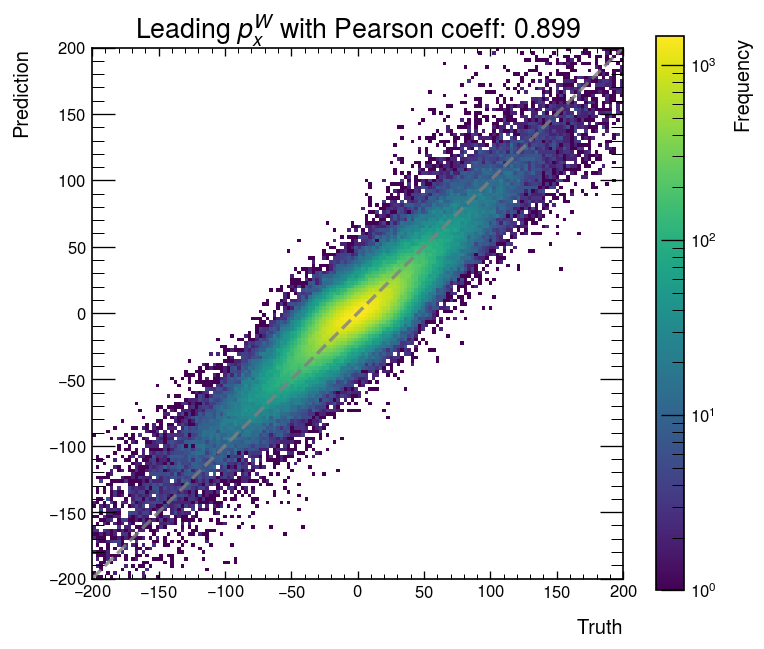

In [ ]:
x, y = int_var[:,1], pred_int[:,1]
print(
    f"Truth mean: {np.mean(x):.3f}, std: {np.std(x):.3f}, min: {np.min(x):.3f}, max: {np.max(x):.3f}"
)

range = [-200, 200]

plot.hist(
    data=[x, y],
    label=r"$p_{x}^{W}$",
    title="Leading $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(x, y):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    x,
    y,
    r"Leading $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(x, y)[0]:.3f}",
    range=range,
)

Truth mean: 0.034, std: 38.223, min: -664.730, max: 609.143


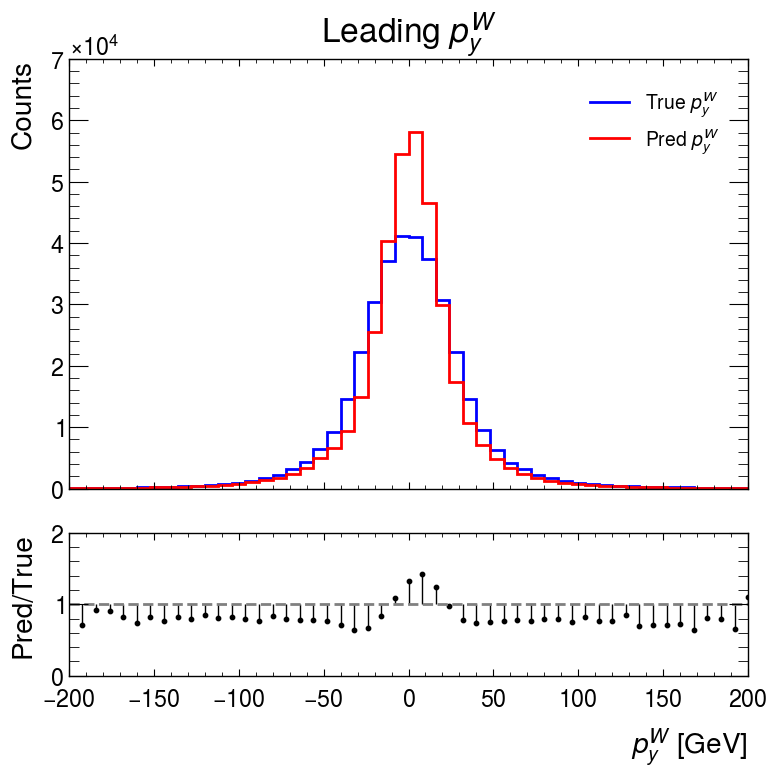

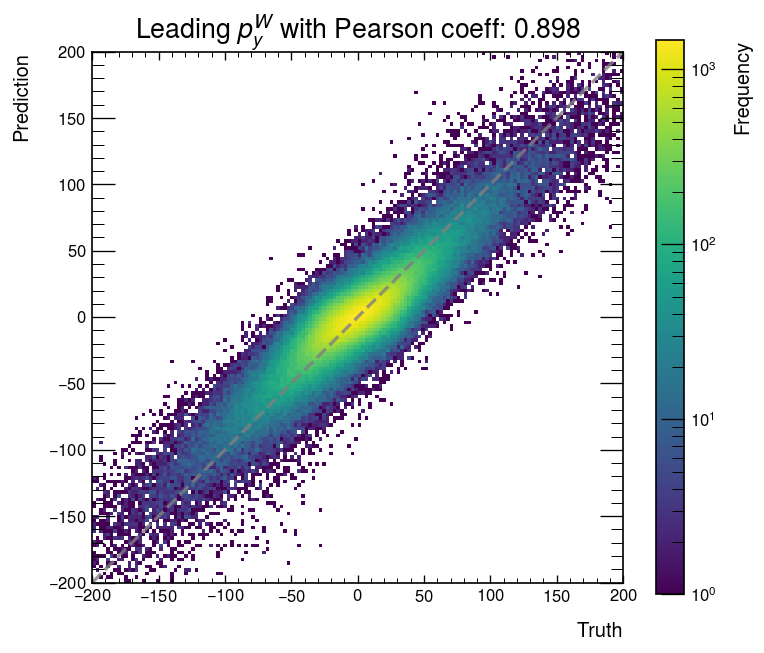

In [ ]:
x, y = int_var[:,2], pred_int[:,2]
print(
    f"Truth mean: {np.mean(x):.3f}, std: {np.std(x):.3f}, min: {np.min(x):.3f}, max: {np.max(x):.3f}"
)

range = [-200, 200]

plot.hist(
    data=[x, y],
    label=r"$p_{y}^{W}$",
    title="Leading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(x, y):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    x,
    y,
    r"Leading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(x, y)[0]:.3f}",
    range=range,
)

Truth mean: 0.184, std: 174.927, min: -1690.593, max: 1793.634


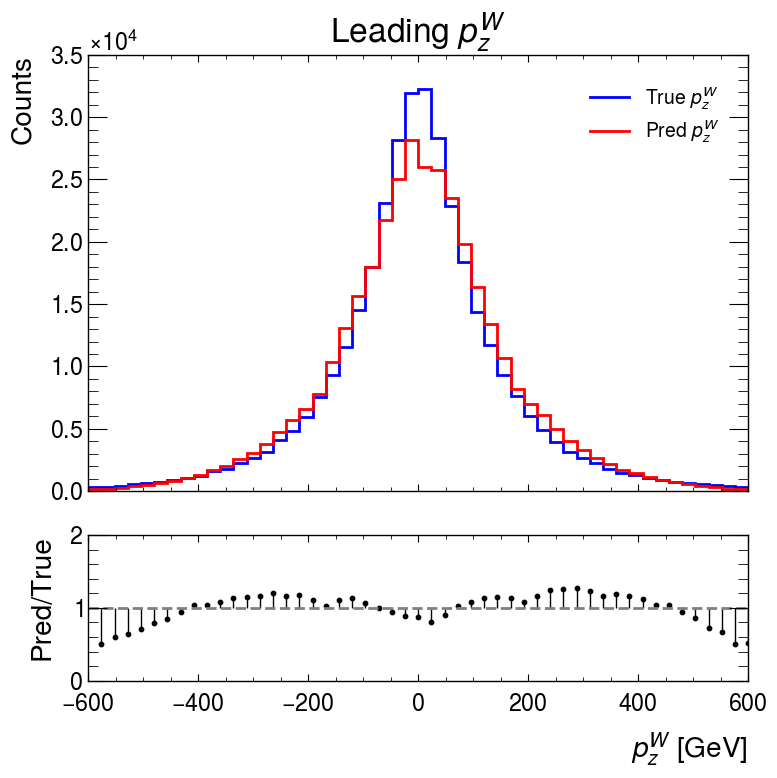

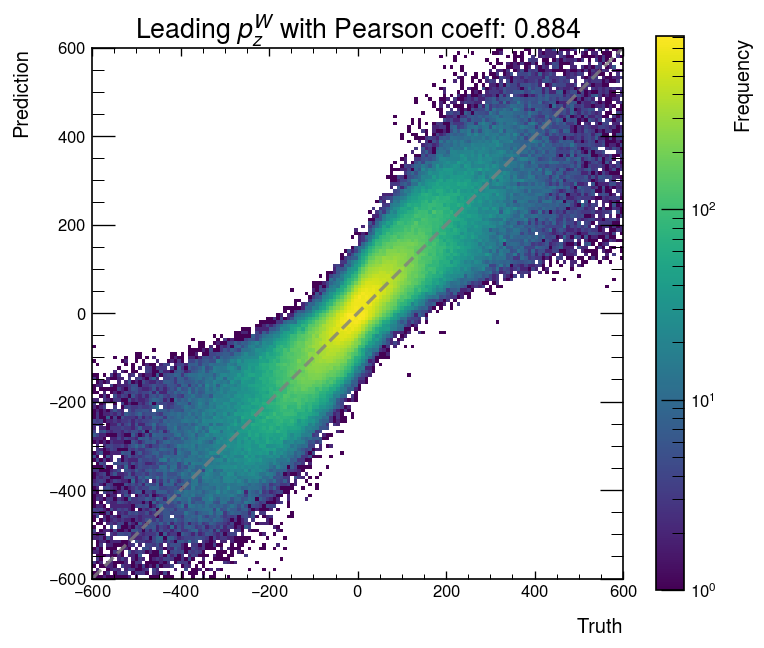

In [ ]:
x, y = int_var[:,3], pred_int[:,3]
print(
    f"Truth mean: {np.mean(x):.3f}, std: {np.std(x):.3f}, min: {np.min(x):.3f}, max: {np.max(x):.3f}"
)

range = [-600, 600]

plot.hist(
    data=[x, y],
    label=r"$p_{z}^{W}$",
    title="Leading $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(x, y):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    x,
    y,
    r"Leading $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(x, y)[0]:.3f}",
    range=range,
)